# Exercise 1: Decision Tree Classifier (30 points)

In this exercise we will train a decision tree classifier for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is to prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background). The dataset is taken from the UCI ML dataset repository.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## part 1(a): Data Exploration and Visualization (10 points)

Explore the dataset before building your ML classifier:
- How many events are in the training data and testing data?
- How many input features are there for each point in the training data?
- Plot at least three of the input features for events with `y_train==0` and for events with `y_train==1`.

Training data shape: (104051, 50)
Testing data shape: (26013, 50)
Number of input features: 50


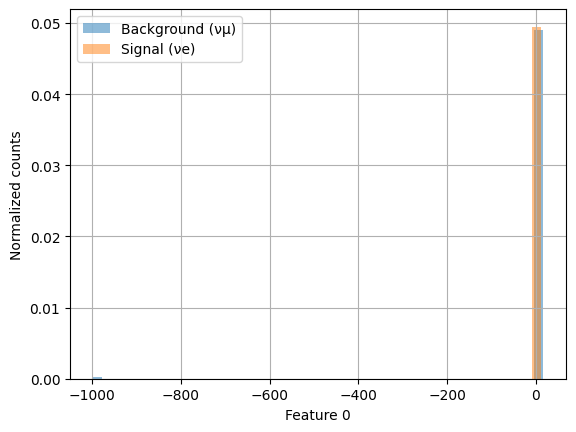

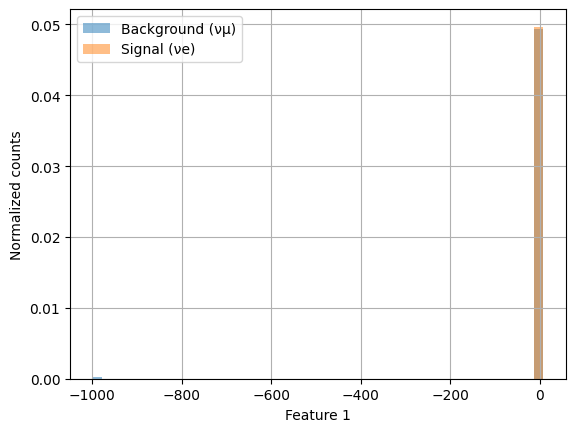

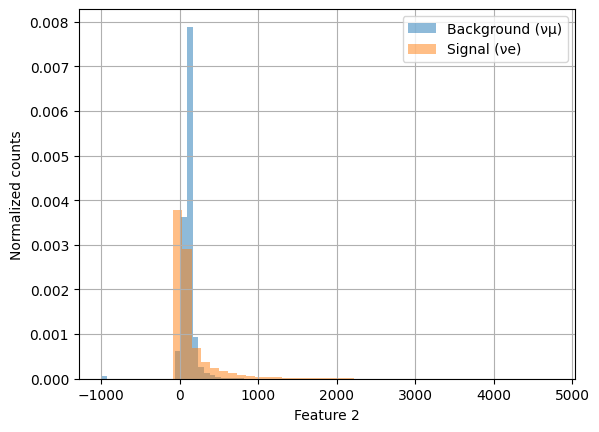

In [9]:
# there are 104051 events in the training data and 26013 in the testing data
# there are 50 input features

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

print("Number of input features:", X_train.shape[1])

import numpy as np

X_signal = X_train[y_train == 1]
X_background = X_train[y_train == 0]

import matplotlib.pyplot as plt

feature_indices = [0, 1, 2]

for i in feature_indices:
    plt.figure()
    plt.hist(X_background[:, i], bins=50, alpha=0.5, label="Background (νμ)", density=True)
    plt.hist(X_signal[:, i], bins=50, alpha=0.5, label="Signal (νe)", density=True)
    plt.xlabel(f"Feature {i}")
    plt.ylabel("Normalized counts")
    plt.legend()
    plt.grid()
    plt.show()


## part 1(b): Decision Tree (10 points)

Train a simple `DecisionTreeClassifier` with `max_depth=5` and the `gini` criterion to separate the electron neutrino signal and muon neutrino background.

Calculate the performance of the Decision Tree:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)


Confusion Matrix:
[[17567  1091]
 [ 1738  5617]]


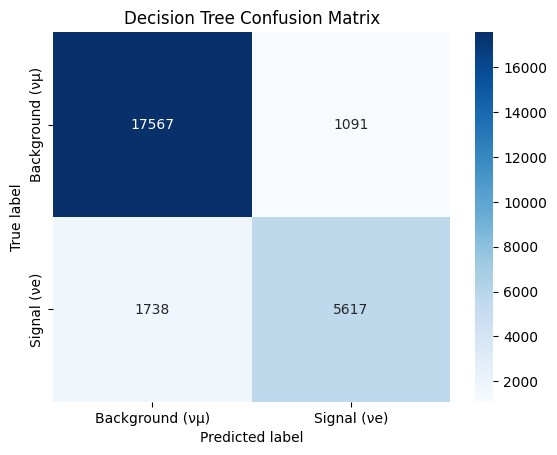

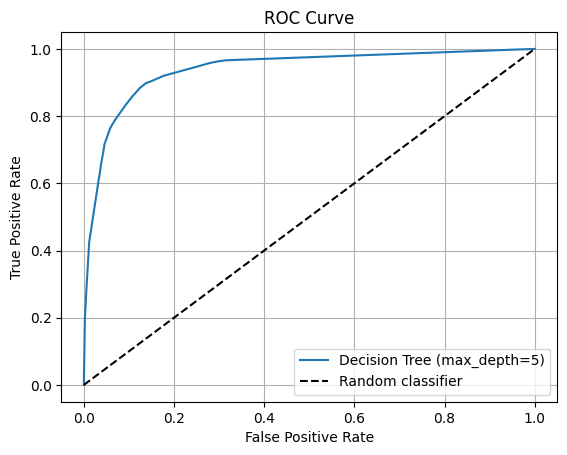

AUC: 0.9380973010266955


In [19]:
# Add code here to train the DecisionTreeClassifier and assess its performance

from sklearn.tree import DecisionTreeClassifier

# Define the decision tree
dt = DecisionTreeClassifier(
    max_depth=5,
    criterion="gini",
    random_state=42
)

# Train the model
dt.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

y_pred = dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Background (νμ)", "Signal (νe)"],
            yticklabels=["Background (νμ)", "Signal (νe)"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# ROC curve

from sklearn.metrics import roc_curve

y_score = dt.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr, label="Decision Tree (max_depth=5)")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Area under curve

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score)
print("AUC:", auc)



## part 1(c): Gini impurity measure

Visualize the decision tree, and pick three of the leaf nodes in your decision tree visualization.

For each node, calculate the Gini impurity by hand to check against the calculation from scikit-learn. Show the steps of your calculation and the result.

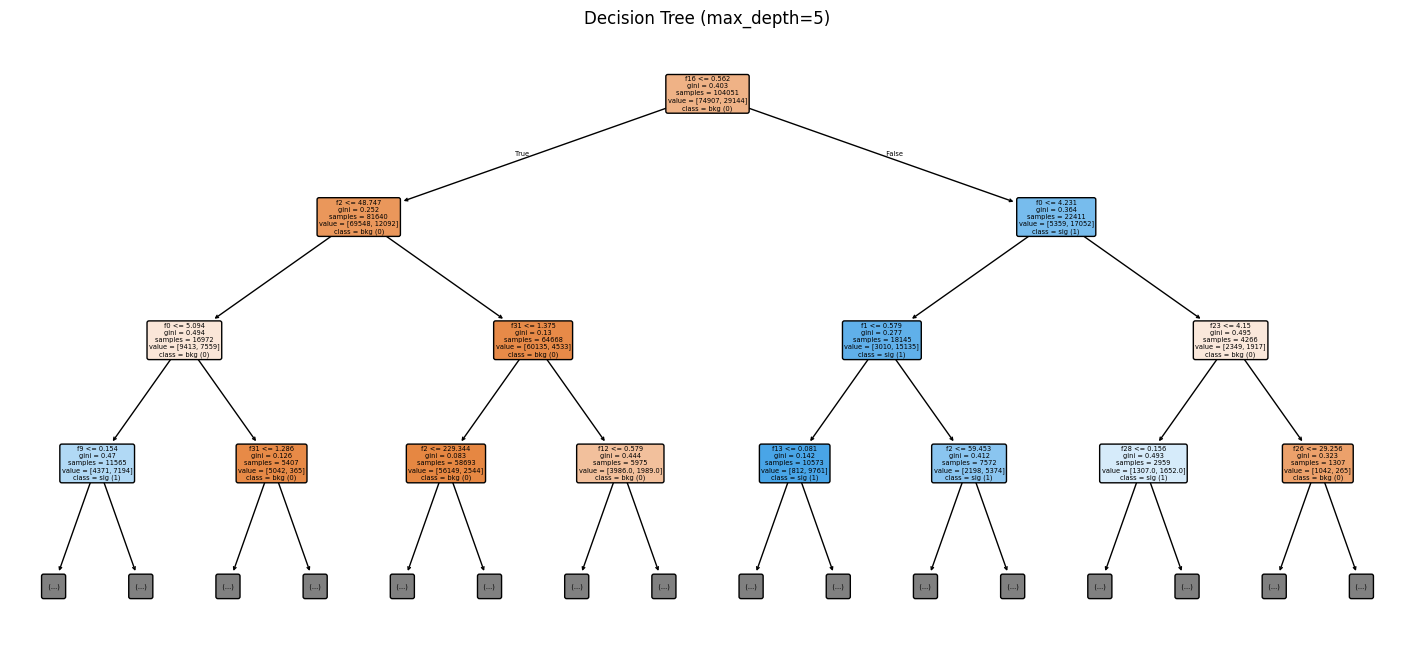

Number of leaf nodes: 32
First few leaf node IDs: [ 5  6  8  9 12 13 15 16 20 21]
Selected leaves (node, N, n0, n1, p1, sklearn_gini):
(np.int64(13), np.float64(1.0), np.float64(0.9872399445214979), np.float64(0.012760055478502081), np.float64(0.012760055478502081), np.float64(0.025194472925375244))
(np.int64(52), np.float64(1.0), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5))
(np.int64(40), np.float64(1.0), np.float64(0.03117059122480095), np.float64(0.9688294087751991), np.float64(0.9688294087751991), np.float64(0.06039797093499466))


In [20]:
# Add code to visualize the decision tree and get impurity measures

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plot_tree(
    dt,
    max_depth=3,                 # keep it readable; remove if you want full tree
    filled=True,
    rounded=True,
    feature_names=[f"f{i}" for i in range(X_train.shape[1])],
    class_names=["bkg (0)", "sig (1)"]
)
plt.title("Decision Tree (max_depth=5)")
plt.show()

import numpy as np

tree = dt.tree_
is_leaf = (tree.children_left == -1) & (tree.children_right == -1)
leaf_ids = np.where(is_leaf)[0]

print("Number of leaf nodes:", len(leaf_ids))
print("First few leaf node IDs:", leaf_ids[:10])

# For binary classification, tree.value[node][0] = [n0, n1]
leaf_info = []
for node in leaf_ids:
    n0, n1 = tree.value[node][0]
    N = n0 + n1
    p1 = n1 / N if N > 0 else 0
    leaf_info.append((node, N, n0, n1, p1, tree.impurity[node]))

# Sort by purity (p1 close to 0 => background-like, close to 1 => signal-like)
leaf_info_sorted = sorted(leaf_info, key=lambda x: x[4])

leaf_bkg = leaf_info_sorted[0]                 # most background-like
leaf_sig = leaf_info_sorted[-1]                # most signal-like
leaf_mix = min(leaf_info, key=lambda x: abs(x[4] - 0.5))  # closest to 50/50

selected = [leaf_bkg, leaf_mix, leaf_sig]
print("Selected leaves (node, N, n0, n1, p1, sklearn_gini):")
for item in selected:
    print(item)



# Exercise 2: Backpropagation (30 points)

In this exercise you will gain some experience with the backpropagation equations and the numerical calculations of the gradient.



## part 2(a): Backpropagation theory (15 points)

Complete the proofs of [Nielsen's equations BP3 and BP4](http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional)).

In Nielsen's notation (but with layer numbers written in parenthesis for clarity):
$$
\begin{align}
\frac{\partial C}{\partial b_j^{(l)}} &= \delta_j^{(l)} & \quad \quad \text{(BP3)} \\
\frac{\partial C}{\partial w_{jk}^{(l)}} &= a_k^{(l-1)} \delta_j^{(l)} & \quad \quad \text{(BP4)}
\end{align}
$$
where $C$ is the cost function (loss function), $w$ and $b$ are weights and biases, $a$ is the post-activation output for the layer, and $\delta$ is the error of a single neuron.

In [21]:
import torch

torch.manual_seed(0)

# One neuron j in layer l with 3 inputs (k=0..2)
a_prev = torch.randn(3, requires_grad=False)          # a^{(l-1)}
w = torch.randn(1, 3, requires_grad=True)             # w^{(l)}_{j,k}
b = torch.randn(1, requires_grad=True)                # b^{(l)}_{j}
y_true = torch.tensor([0.7])

# forward: z = w a + b, a = sigmoid(z)
z = (w @ a_prev) + b
a = torch.sigmoid(z)

# cost: simple squared error
C = 0.5 * (a - y_true).pow(2).sum()

# autograd gradients
C.backward()

# compute delta = dC/dz by chain rule
# dC/da = (a - y)
# da/dz = a(1-a)
delta = (a - y_true) * a * (1 - a)

print("autograd dC/db:", b.grad.item())
print("delta:", delta.item())

print("autograd dC/dw:", w.grad)
print("a_prev * delta:", a_prev * delta)


autograd dC/db: 0.00273910746909678
delta: 0.00273910746909678
autograd dC/dw: tensor([[ 0.0042, -0.0008, -0.0060]])
a_prev * delta: tensor([ 0.0042, -0.0008, -0.0060], grad_fn=<MulBackward0>)


## part 2(b): Numerical calculation (15 points)

Consider a single perceptron node with 1-dimensional input $x$. The weight and bias of the node are $w=0.5$ and $b=0.1$. We use the ReLU activation function on the output of the node and the mean square error loss function.

If the data input and target are $x=1, y=1$:
- What is the loss function value?
- What is the gradient $\partial L/\partial w$?
- What is the gradient $\partial L/\partial b$?

You can do this by hand. Show your work, and feel free to check your answer with some code.




In [22]:
import torch

x = torch.tensor([1.0])
y = torch.tensor([1.0])

w = torch.tensor([0.5], requires_grad=True)
b = torch.tensor([0.1], requires_grad=True)

z = w*x + b
a = torch.relu(z)
L = (a - y)**2   # use 0.5*(a-y)**2 if your class uses the 1/2

L.backward()

print("z =", z.item())
print("a =", a.item())
print("Loss =", L.item())
print("dL/dw =", w.grad.item())
print("dL/db =", b.grad.item())


z = 0.6000000238418579
a = 0.6000000238418579
Loss = 0.15999998152256012
dL/dw = -0.7999999523162842
dL/db = -0.7999999523162842


# Exercise 3: Deep Neural Networks (40 points)

In this exercise we will train a deep neural network for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is similar to Exercise 1 above: prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background).

In this exercise, you will set up a neural network model using PyTorch and train it using the MiniBOONE training data, then test it on the testing data.

## part 3(a) (20 points): DNN with tanh activation

Implement a deep neural network (at least 1 hidden layer between the input and output layers) to classify events as electron neutrinos (signal) or muon neutrinos (background). Use the tanh activation function, except in the output layer.

Here are some starting points for the DNN:
- 3 hidden layers w/ 64 units each
- BCE loss function
- SGD optimizer w/ batch size of 128

You should expect to train for at least 50 epochs.

In [ ]:
# Put code here to implement the DNN to classify neutrino events
# You can use the examples from class and the hands-on notebooks

# prepare PyTorch

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

# Define DNN
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()   # output layer: probability
        )

    def forward(self, x):
        return self.net(x)

model = DNN(input_dim=X_train.shape[1])

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
def accuracy_from_probs(probs, labels):
    preds = (probs >= 0.5).float()
    return (preds == labels).float().mean().item()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        probs = model(xb)
        loss = criterion(probs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_probs(probs.detach(), yb)
        n_batches += 1

    train_loss = running_loss / n_batches
    train_acc  = running_acc / n_batches

    # Evaluate on test set each epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        n_test_batches = 0
        for xb, yb in test_loader:
            probs = model(xb)
            loss = criterion(probs, yb)
            test_loss += loss.item()
            test_acc += accuracy_from_probs(probs, yb)
            n_test_batches += 1
        test_loss /= n_test_batches
        test_acc  /= n_test_batches

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"train loss {train_loss:.4f}, acc {train_acc:.4f} | "
              f"test loss {test_loss:.4f}, acc {test_acc:.4f}")


Epoch   1/50 | train loss 0.4502, acc 0.7962 | test loss 0.4009, acc 0.8231
Epoch   5/50 | train loss 0.4371, acc 0.8165 | test loss 0.4362, acc 0.8413
Epoch  10/50 | train loss 0.4739, acc 0.7950 | test loss 0.4137, acc 0.8241
Epoch  15/50 | train loss 0.4365, acc 0.8197 | test loss 0.4371, acc 0.8283
Epoch  20/50 | train loss 0.4439, acc 0.7980 | test loss 0.4355, acc 0.8419
Epoch  25/50 | train loss 0.4291, acc 0.8234 | test loss 0.4169, acc 0.8397
Epoch  30/50 | train loss 0.4272, acc 0.8246 | test loss 0.4263, acc 0.8359
Epoch  35/50 | train loss 0.4360, acc 0.8265 | test loss 0.4262, acc 0.8423


## part 3(b) (10 points): DNN performance assessment

Calculate the performance of the DNN on the testing data:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)



In [ ]:
# Put code here to assess the DNN performance
# You can use the examples from class and the hands-on notebooks

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# Make sure model is in eval mode
model.eval()

# Get predicted probabilities on the test set
with torch.no_grad():
    probs_test = model(X_test_t).cpu().numpy().flatten()  # probabilities in [0,1]

# True labels as numpy array
y_test_np = y_test_t.cpu().numpy().flatten().astype(int)

# Convert probabilities to hard predictions using 0.5 threshold
y_pred_np = (probs_test >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background (0)", "Signal (1)"])
disp.plot(values_format="d")
plt.title("DNN Confusion Matrix")
plt.grid(False)
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_np, probs_test)

plt.figure()
plt.plot(fpr, tpr, label="DNN ROC")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DNN)")
plt.legend()
plt.grid()
plt.show()

# AUC
auc = roc_auc_score(y_test_np, probs_test)
print("AUC:", auc)




## part 3(c) (10 points): Change of activation function

Replace the tanh activation functions with the ReLU activation functions, in the layers where it is possible.
(Hint: there is one layer where you can't use the ReLU activation function--why not?)

What happens with the training and performance? Can you improve the performance relative to the original training with sigmoid activation functions?

In [ ]:
# Put code here to change the activation functions to ReLU,
# then retrain and re-assess the performance.
# (It's reasonable to cut-and-paste from the code in part 3(a).)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class DNN_ReLU(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()   # keep sigmoid here (output probability)
        )

    def forward(self, x):
        return self.net(x)

model_relu = DNN_ReLU(input_dim=X_train.shape[1])

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_relu.parameters(), lr=0.01)

num_epochs = 50

def batch_accuracy(probs, y):
    preds = (probs >= 0.5).float()
    return (preds == y).float().mean().item()

for epoch in range(num_epochs):
    model_relu.train()
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        probs = model_relu(xb)
        loss = criterion(probs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += batch_accuracy(probs.detach(), yb)
        n_batches += 1

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} "
              f"| loss {running_loss/n_batches:.4f} "
              f"| acc {running_acc/n_batches:.4f}")
